In [22]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy

import albumentations as A
from albumentations.pytorch import ToTensorV2

from math import ceil
import seaborn as sn

In [24]:
from sklearn.metrics import confusion_matrix, f1_score

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{bcolors.OK}{device}{bcolors.RESET}')

cuda:0


In [26]:
hyper_parameter = {
    "attempt": 1,
    "model": 'resnet',
    "version": '152',
    "learning_rate": 0.001,
    "batch_size": 1,
    "num_workers": 2,
    "no_epochs": 5,
    "image_size": 224, 
    "in_channels": 3, 
    "num_classes": 8,
    "load_model": True
}

In [27]:
data_dir = 'D:\sl\images'
sets = ['train', 'test']
# to use checkpoint saving create a directory named "checkpoint" and a sub directory in the name of the model
checkpoint_path = f'./checkpoints/{hyper_parameter["model"]}/{hyper_parameter["model"]}{hyper_parameter["version"]}-{hyper_parameter["attempt"]}'


print(f'{bcolors.OK}Enviroment setup complete 😊🐼!{bcolors.RESET}')

Enviroment setup complete 😊🐼!


In [28]:
classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
image_frequency = pd.DataFrame(columns=sets, index=classes)
for dataset in iter(sets):
    for classname in iter(classes):
        image_frequency[dataset][classname] = len(os.listdir(os.path.join(data_dir, dataset, classname)))
image_frequency.index = image_frequency.index.rename('classes')

print(image_frequency.to_markdown())
print(image_frequency.sum(axis=0))

| classes   |   train |   test |
|:----------|--------:|-------:|
| AK        |     689 |    178 |
| BCC       |    2669 |    654 |
| BKL       |    2077 |    547 |
| DF        |     180 |     59 |
| MEL       |    3608 |    914 |
| NV        |   10330 |   2545 |
| SCC       |     509 |    119 |
| VASC      |     203 |     50 |
train    20265
test      5066
dtype: object


In [29]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [30]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

data_transforms = {
    'train': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()]),
    'test': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()])
}

In [31]:
# create dataset and dataloader
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =Transforms(transforms=data_transforms[x])) for x in sets}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=hyper_parameter['batch_size'], shuffle=True) for x in sets}

dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes

print('train: {} test: {}'.format(dataset_sizes['train'], dataset_sizes['test']))
print(class_names)

train: 20265 test: 5066
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


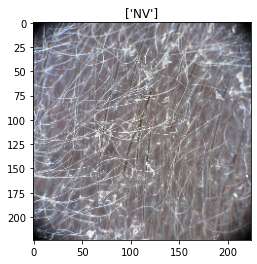

In [32]:
def imshow(inp, title):
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

images, classes = next(iter(dataloaders['train']))

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid, title=[class_names[x] for x in classes])

In [33]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [34]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    
    def forward(self, x):
        return x

In [35]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)

In [36]:
version = hyper_parameter['version']
model = Identity()

In [37]:
model = ResNet152(img_channel=3, num_classes=8)
print(model.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 

In [38]:
model.to(device)

next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = hyper_parameter['learning_rate'])

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:
train_results = {
    'accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'f1_score': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'loss': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'cf_matrix': np.zeros((hyper_parameter['num_classes'], hyper_parameter['num_classes']), dtype=float)
}

test_results = {
    'accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'f1_score': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'loss': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'cf_matrix': np.zeros((hyper_parameter['num_classes'], hyper_parameter['num_classes']), dtype=float)
}

results = {
    'train': train_results,
    'test': test_results
}

In [40]:
save_path = f'{checkpoint_path}.pth.tar'

def save_checkpoint(state, epoch, filename = save_path):
    print(f'=> Checkpoint at {epoch + 1} saved!')
    print(f'Saved at: {save_path}')
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print(f'=> Loading Checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [41]:
def train_model(model, cirterion, optimizer, scheduler, num_epochs = 1):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_f1_scr = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 15)

    for phase in ['train', 'test']:
      if phase =='train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      real_targets = []
      predicted_targets = []

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history only if train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          
          real_targets.extend(labels.detach().cpu().numpy())
          predicted_targets.extend(preds.detach().cpu().numpy())

          loss = cirterion(outputs, labels)

          #backward + optimize only if in train
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      ### EPOCH Train & Test ###
      if phase == 'train':
        scheduler.step()

      sk_f1 = f1_score(predicted_targets, real_targets, average='micro')
      epoch_cf_matrix = confusion_matrix(real_targets, predicted_targets)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]

      results[phase]['accuracy'][epoch] = epoch_acc
      results[phase]['loss'][epoch] = epoch_loss
      results[phase]['f1_score'][epoch] = sk_f1
      results[phase]['cf_matrix'] += epoch_cf_matrix

      # printing epoch resutlts
      print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
      print(f'{phase} F1 Score: {sk_f1:.4f}')

      epoch_time = time.time() - since
      print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time %  60:.0f}s')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      
      if phase == 'test' and sk_f1 > best_f1_scr:
        best_f1_scr = sk_f1
    
    if (epoch + 1) % 2 == 0:
      checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
      }
      save_checkpoint(checkpoint, epoch)

    print()
    ######################################################

  # training Complete
  # printing time require to train model
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')

  t = time.localtime()
  current_time = time.strftime("%H:%M", t)
  print(f'Trainig completed at {current_time}')
  print(f'Best val Acc: {best_acc:4f}')
  print(f'Best sk F1 : {best_f1_scr:4f}')

  for phase in ['train', 'test']:
    df_cm = pd.DataFrame(results[phase]['cf_matrix'], index = class_names, columns = class_names)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
  plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_cf_matrix.png')
  plt.show()

  for phase in ['train', 'test']:
    plt.plot(results[phase]['accuracy'], label='{} accuracy'.format(phase))
    plt.legend(loc='upper right')
  plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_accuracy.png')
  plt.show()

  for phase in ['train', 'test']:
    plt.plot(results[phase]['f1_score'], label='{} f1 score'.format(phase))
    plt.legend(loc='upper right')
  plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_f1_score.png')
  plt.show()
  
  for phase in ['train', 'test']:
    plt.plot(results[phase]['loss'], label='{} loss'.format(phase))
    plt.legend(loc='upper right')
  plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_loss.png')
  plt.show()

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

Epoch 1/5
---------------
train Loss: 1.5018, Acc: 0.5023
train F1 Score: 0.5023
Epoch time: 83m 41s
test Loss: 1.8891, Acc: 0.5024
test F1 Score: 0.5024
Epoch time: 90m 52s

Epoch 2/5
---------------
train Loss: 1.4215, Acc: 0.5120
train F1 Score: 0.5120
Epoch time: 166m 28s
test Loss: 4.5595, Acc: 0.4880
test F1 Score: 0.4880
Epoch time: 172m 25s
=> Checkpoint at 2 saved!
Saved at: ./checkpoints/resnet/resnet152-1.pth.tar

Epoch 3/5
---------------
train Loss: 1.2688, Acc: 0.5532
train F1 Score: 0.5532
Epoch time: 248m 2s
test Loss: 4.6572, Acc: 0.4098
test F1 Score: 0.4098
Epoch time: 253m 57s

Epoch 4/5
---------------
train Loss: 1.1724, Acc: 0.5821
train F1 Score: 0.5821
Epoch time: 329m 32s
test Loss: 1.7304, Acc: 0.4080
test F1 Score: 0.4080
Epoch time: 335m 29s
=> Checkpoint at 4 saved!
Saved at: ./checkpoints/resnet/resnet152-1.pth.tar

Epoch 5/5
---------------
train Loss: 1.1178, Acc: 0.6006
train F1 Score: 0.6006
Epoch time: 411m 3s
test Loss: 1.8875, Acc: 0.4185
test F1 S

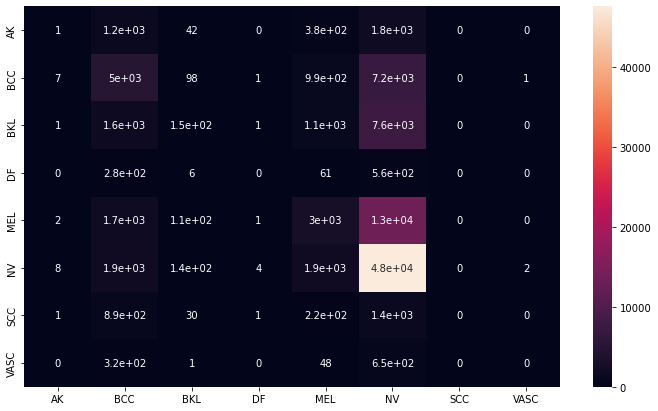

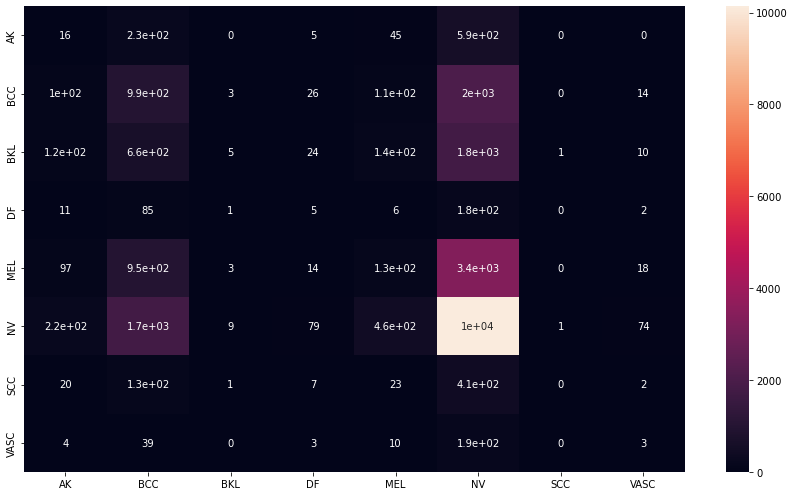

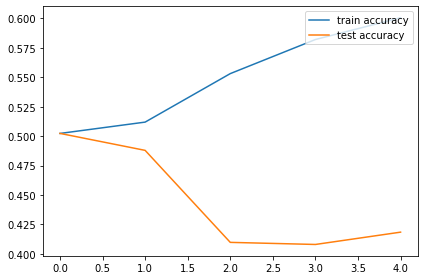

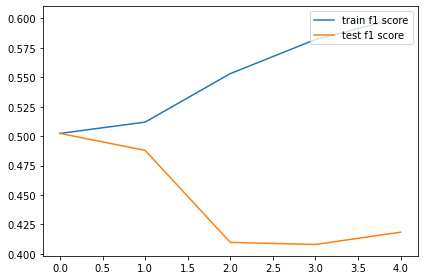

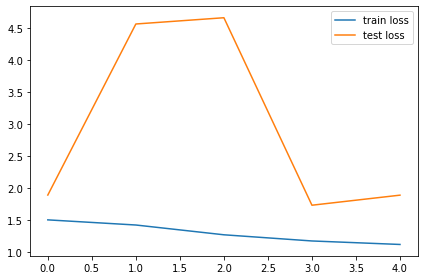

In [42]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=hyper_parameter['no_epochs'])